In [2]:
from feature_create_select.feature_create import AutoCreate

In [2]:
import featuretools as ft

In [3]:
data = ft.demo.load_mock_customer()

In [4]:
auto_c = AutoCreate()

In [5]:
customers_df = data['customers']
sessions_df = data["sessions"]
transactions_df = data["transactions"]

In [6]:
transactions_df.head()

,transaction_id,session_id,transaction_time,product_id,amount
0,298,1,2014-01-01 00:00:00,5,127.64
1,2,1,2014-01-01 00:01:05,2,109.48
2,308,1,2014-01-01 00:02:10,3,95.06
3,116,1,2014-01-01 00:03:15,4,78.92
4,371,1,2014-01-01 00:04:20,3,31.54


In [7]:
transactions_df['product_id'].unique()

[5, 2, 3, 4, 1]
Categories (5, int64): [5, 2, 3, 4, 1]

In [8]:
#可以参考featuretools 里面的类型进行定义,打印dtypes 对于类型不正确或object进行定义
auto_c.create_entity('customers',customers_df,index = 'customer_id',
                    time_index = 'join_date',
                    variable_types={"zip_code": ft.variable_types.ZIPCode})

In [9]:
auto_c.create_entity('sessions',sessions_df,index = 'session_id',
                    time_index = 'session_start',
                    variable_types={"device": ft.variable_types.Categorical})

In [10]:
auto_c.create_entity('transactions',transactions_df,index = 'transaction_id',
                    time_index = 'transaction_time',
                    variable_types={"product_id": ft.variable_types.Categorical})

In [11]:
auto_c.add_relation(['customers.customer_id','sessions.customer_id','sessions.session_id','transactions.session_id'])

In [12]:
auto_c.focus_value('transactions','product_id',interesting_values=[1,2,3])

In [13]:
from featuretools.primitives import TimeSince
time_since = TimeSince(unit="days")

In [14]:
simple_matrix,features_def = auto_c.make_features(target_entity="customers",agg_primitives = ['mean', 'max', 'percent_true', 'last','count'],trans_primitives = ['year', 'month', time_since],where_primitives=['count'])

In [15]:
# 定义自定义函数以及指定不同的列使用不同的函数
from featuretools.primitives import make_agg_primitive, make_trans_primitive
import numpy as np
def maxmin(column):
    return max(column)-min(column)
Maxmin = make_agg_primitive(function=maxmin,
                      input_types=[ft.variable_types.Numeric],
                      return_type=ft.variable_types.Numeric)
def get_addr(column):
    pro = np.array([item[:3] for item in column])
    city = np.array([item[3:] for item in column])
    return [pro,city]
Addr = make_trans_primitive(function=get_addr,
                        input_types=[ft.variable_types.ZIPCode],
                        return_type=ft.variable_types.Categorical,
                        number_output_features=2)

In [16]:
c_matrix,features_def = auto_c.make_features(target_entity="customers",agg_primitives = ['mean', 'max', 'percent_true', 'last',Maxmin,'count'],trans_primitives = ['year', 'month', 'time_since',Addr],where_primitives=['count'])

In [17]:
option_matrix,features_def = auto_c.make_features(
                        target_entity="customers",
                        agg_primitives = ['mean', 'max','percent_true', 'last',Maxmin,'count'],
                        trans_primitives = ['year', 'month', 'time_since',Addr],                                       where_primitives=['count'],ignore_entities=[],
                        ignore_variables={'customers': ['date_of_birth']},
                        primitive_options={'time_since': {
                        'ignore_entities': ['sessions']},
                        Maxmin: {'include_variables':{'transactions':['amount']}}})

In [18]:
clean_matrix,features_def=auto_c.clean_features(option_matrix,features_def)

In [19]:
# 丢弃zip_code，将其他object的列转为category
import pandas as pd
df_types = pd.DataFrame(clean_matrix.dtypes).reset_index().rename(columns = {'index': 'feature', 0: 'type_name'}).astype('str')

In [20]:
object_col = df_types[df_types['type_name']=='object']['feature'].tolist()
convert_col = [item for item in object_col if item !='zip_code']

In [21]:
clean_matrix[convert_col] = clean_matrix[convert_col].astype('category')

In [22]:
# 可以使用 to_encode参数指定需要one-hot 的列
final_matrix,final_fd = auto_c.get_final_data(clean_matrix,features_def)

2020-11-19 18:10:32,830 featuretools - WARNING    Feature <Feature: GET_ADDR(zip_code)> has multiple columns and will not be encoded.  This may result in a matrix with non-numeric values.


In [23]:
final_fd

[<Feature: COUNT(sessions)>,
 <Feature: LAST(sessions.device) = mobile>,
 <Feature: LAST(sessions.device) = desktop>,
 <Feature: LAST(sessions.device) is unknown>,
 <Feature: LAST(sessions.session_id) = 35>,
 <Feature: LAST(sessions.session_id) = 33>,
 <Feature: LAST(sessions.session_id) = 32>,
 <Feature: LAST(sessions.session_id) = 29>,
 <Feature: LAST(sessions.session_id) = 22>,
 <Feature: LAST(sessions.session_id) is unknown>,
 <Feature: COUNT(transactions)>,
 <Feature: LAST(transactions.amount)>,
 <Feature: LAST(transactions.product_id) = 1>,
 <Feature: LAST(transactions.product_id) = 4>,
 <Feature: LAST(transactions.product_id) = 3>,
 <Feature: LAST(transactions.product_id) = 2>,
 <Feature: LAST(transactions.product_id) is unknown>,
 <Feature: LAST(transactions.transaction_id) = 385>,
 <Feature: LAST(transactions.transaction_id) = 203>,
 <Feature: LAST(transactions.transaction_id) = 104>,
 <Feature: LAST(transactions.transaction_id) = 85>,
 <Feature: LAST(transactions.transaction_

In [24]:
#使用remove_features丢弃_id 列,得到最终的Features 为了最终使用deploy_features_create
drop_cols = [item for item in final_matrix.columns if '_id' in item]

In [25]:
deploy_matrix,deploy_fd= auto_c.remove_features(drop_cols,final_matrix,features_enc=final_fd)

In [26]:
deploy_matrix

,COUNT(sessions),LAST(sessions.device) = mobile,LAST(sessions.device) = desktop,LAST(sessions.device) is unknown,COUNT(transactions),LAST(transactions.amount),MAX(transactions.amount),MEAN(transactions.amount),GET_ADDR(zip_code)[0],GET_ADDR(zip_code)[1],...,MAX(sessions.MAXMIN(transactions.amount)),MAX(sessions.MEAN(transactions.amount)),MAXMIN(sessions.LAST(transactions.amount)),MAXMIN(sessions.MAX(transactions.amount)),MAXMIN(sessions.MAXMIN(transactions.amount)),MEAN(sessions.COUNT(transactions)),MEAN(sessions.MAX(transactions.amount)),LAST(transactions.sessions.device) = mobile,LAST(transactions.sessions.device) = desktop,LAST(transactions.sessions.device) is unknown
customer_id,,,,,,,,,,,,,,,,,,,,,
5,6,True,False,False,79,111.02,149.02,80.375443,600,91,...,136.98,94.481667,124.74,20.51,29.12,13.166667,139.960000,True,False,False
4,8,False,True,False,109,127.71,149.95,80.070459,600,91,...,143.11,110.450000,142.52,10.75,54.78,13.625000,144.748750,False,True,False
1,8,True,False,False,126,67.43,139.43,71.631905,600,91,...,133.52,88.755625,103.39,20.53,26.39,15.750000,132.246250,True,False,False
3,6,True,False,False,93,148.31,149.15,67.060430,132,44,...,143.26,82.109444,107.43,22.41,35.06,15.500000,141.271667,True,False,False
2,7,True,False,False,93,66.80,146.81,77.422366,132,44,...,134.74,96.581000,109.63,46.77,52.82,13.285714,133.090000,True,False,False


In [27]:
# save/load deploy_fd
auto_c.deploy_features_create(deploy_fd,'feature_definitions.json')

In [28]:
#加载保存的model,并转化数据
feature_df_load = AutoCreate.load_features_create('feature_definitions.json')

In [29]:
new_ac = AutoCreate()

In [30]:
# 加载数据与关系(也可以传入通过AutoCreate构建的auto_create)
entities = {"customers" : (customers_df, "customer_id"),
    "sessions" : (sessions_df, "session_id", "session_start"),
    "transactions" : (transactions_df, "transaction_id", "transaction_time")}
relationships = [("sessions", "session_id", "transactions", "session_id"),
                ("customers", "customer_id", "sessions", "customer_id")]

In [31]:
conv_matrix = new_ac.make_features(entities=entities, relationships=relationships,features=feature_df_load)

In [32]:
conv_matrix

,COUNT(sessions),LAST(sessions.device) = mobile,LAST(sessions.device) = desktop,LAST(sessions.device) is unknown,COUNT(transactions),LAST(transactions.amount),MAX(transactions.amount),MEAN(transactions.amount),GET_ADDR(zip_code)[0],GET_ADDR(zip_code)[1],...,MAX(sessions.MAXMIN(transactions.amount)),MAX(sessions.MEAN(transactions.amount)),MAXMIN(sessions.LAST(transactions.amount)),MAXMIN(sessions.MAX(transactions.amount)),MAXMIN(sessions.MAXMIN(transactions.amount)),MEAN(sessions.COUNT(transactions)),MEAN(sessions.MAX(transactions.amount)),LAST(transactions.sessions.device) = mobile,LAST(transactions.sessions.device) = desktop,LAST(transactions.sessions.device) is unknown
customer_id,,,,,,,,,,,,,,,,,,,,,
1,8,True,False,False,126,67.43,139.43,71.631905,600,91,...,133.52,88.755625,103.39,20.53,26.39,15.750000,132.246250,True,False,False
2,7,True,False,False,93,66.80,146.81,77.422366,132,44,...,134.74,96.581000,109.63,46.77,52.82,13.285714,133.090000,True,False,False
3,6,True,False,False,93,148.31,149.15,67.060430,132,44,...,143.26,82.109444,107.43,22.41,35.06,15.500000,141.271667,True,False,False
4,8,False,True,False,109,127.71,149.95,80.070459,600,91,...,143.11,110.450000,142.52,10.75,54.78,13.625000,144.748750,False,True,False
5,6,True,False,False,79,111.02,149.02,80.375443,600,91,...,136.98,94.481667,124.74,20.51,29.12,13.166667,139.960000,True,False,False


In [33]:
from auto_select_feature import AutoSelect

In [34]:
labels = [0,0,1,1,0]

In [35]:
auto_s1 = AutoSelect(conv_matrix,labels)

In [36]:
auto_s1.sk_feature_importances(0.99)

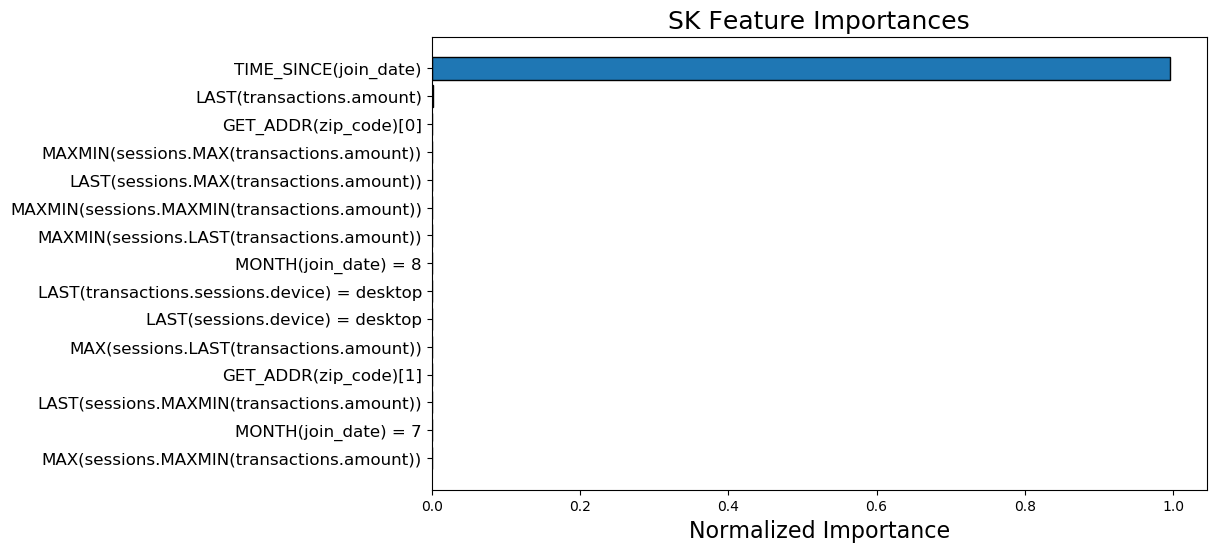

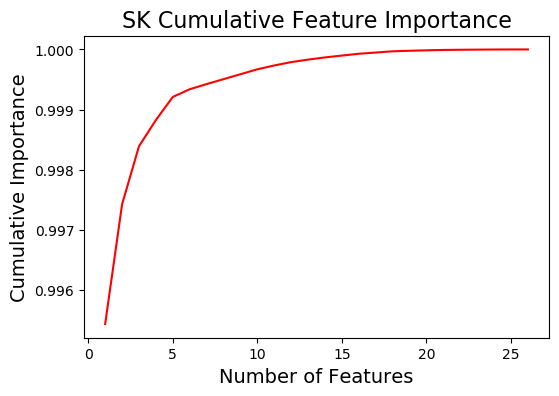

In [37]:
auto_s1.skplot_feature_importances()